<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Higgs_Boson_Classification_QMAML%20v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Download and unzip the Higgs dataset
!wget -O HIGGS.csv.gz https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2025-06-11 12:53:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz            [   <=>              ]   2.62G  17.8MB/s    in 4m 23s  

2025-06-11 12:58:23 (10.2 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858]



In [2]:
!gunzip HIGGS.csv.gz

gzip: HIGGS.csv already exists; do you wish to overwrite (y or n)? y


In [3]:
# Install PennyLane and XGBoost if not already installed
!pip install pennylane xgboost --quiet

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import pennylane as qml
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [5]:
CSV_PATH = 'HIGGS.csv'
N_TRAIN = 300_000
N_META_TEST = 60_000
N_FEATURES = 40
N_CLASSES = 2

# PQC/QNN
N_QUBITS = 16
PQC_LAYERS = 4

# Classical meta-initializer (MLP for PQC params)
META_INIT_HIDDEN = 128

# PQC-to-MLP mapping
PQC_TO_MLP_HIDDEN = [256, 512, 1024]  # Deep, wide mapping MLP

# Meta-learner (PhysicsMLP)
HIDDEN_SIZE = 1024
N_LAYERS = 6
DROPOUT = 0.4

# Meta-learning
META_TRAIN_TASKS = 50
META_TEST_TASKS = 10
META_INNER_STEPS = 10
META_INNER_LR = 0.03
META_OUTER_LR = 0.0003
META_SUPPORT = 512
META_QUERY = 2048
N_EPOCHS = 10

In [6]:
class HiggsDataset(Dataset):
    def __init__(self, csv_path, n_samples=None, offset=0, add_physics_features=True):
        df = pd.read_csv(csv_path, header=None, nrows=n_samples, skiprows=range(1, offset+1))
        X = df.iloc[:, 1:].values.astype(np.float32)
        if add_physics_features:
            X = np.concatenate([
                X,
                np.log1p(np.abs(X[:, :5])),
                np.sqrt(np.abs(X[:, :5])),
                X[:, [0]] * X[:, [1]],
                X[:, [2]] / (X[:, [3]] + 1e-6)
            ], axis=1)
        self.X = X
        self.y = df.iloc[:, 0].values.astype(np.int64)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

In [7]:
# 4. PQC (QNN), classical meta-initializer, and improved PQC-to-MLP mapping

dev = qml.device("default.qubit", wires=N_QUBITS)

def angle_encode(x):
    for i in range(N_QUBITS):
        qml.RY(x[i], wires=i)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def pqc_circuit(weights, x):
    angle_encode(x)
    for l in range(weights.shape[0]):
        for i in range(N_QUBITS):
            qml.RY(weights[l, i, 0], wires=i)
            qml.RZ(weights[l, i, 1], wires=i)
        for i in range(N_QUBITS - 1):
            qml.CNOT(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class PQCMetaInitializer(nn.Module):
    def __init__(self, emb_dim, pqc_layers, n_qubits):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, META_INIT_HIDDEN),
            nn.ReLU(),
            nn.Linear(META_INIT_HIDDEN, pqc_layers * n_qubits * 2)
        )
        self.pqc_layers = pqc_layers
        self.n_qubits = n_qubits
    def forward(self, emb):
        out = self.mlp(emb)
        return out.view(self.pqc_layers, self.n_qubits, 2)

class PQCtoMLPMapper(nn.Module):
    def __init__(self, pqc_dim, mlp_param_dim, hidden_dims=[256, 512, 1024]):
        super().__init__()
        layers = []
        last_dim = pqc_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.LayerNorm(h))
            layers.append(nn.Dropout(0.2))
            last_dim = h
        layers.append(nn.Linear(last_dim, mlp_param_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, pqc_out):
        return self.net(pqc_out)

In [8]:
# 5. Task embedding and PhysicsMLP
def task_embedding(task):
    emb = torch.zeros(N_QUBITS)
    emb[:len(task['classes'])] = torch.tensor(task['classes']).float() / 10.0
    emb[-1] = torch.rand(1)
    return emb

class PhysicsMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=1024, output_dim=2, n_layers=6, activation='gelu', dropout=0.4):
        super().__init__()
        act = {
            'leakyrelu': nn.LeakyReLU(),
            'elu': nn.ELU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU()
        }[activation]
        layers = [nn.BatchNorm1d(input_dim)]
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(act)
            layers.append(nn.LayerNorm(hidden_dim))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [9]:
# 6. Prepare meta-tasks (few-shot tasks)
def prepare_meta_tasks(dataset, n_tasks, n_way, k_shot, k_query):
    labels = np.array(dataset.y)
    classes_all = np.unique(labels)
    tasks = []
    for _ in range(n_tasks):
        classes = np.random.choice(classes_all, n_way, replace=False)
        support_x, support_y, query_x, query_y = [], [], [], []
        for i, c in enumerate(classes):
            idx = np.where(labels == c)[0]
            if len(idx) < k_shot + k_query:
                continue
            perm = np.random.permutation(idx)
            support_idx = perm[:k_shot]
            query_idx = perm[k_shot:k_shot + k_query]
            support_x.append(dataset.X[support_idx])
            support_y.append(np.full((k_shot,), i))
            query_x.append(dataset.X[query_idx])
            query_y.append(np.full((k_query,), i))
        if len(support_x) < n_way:
            continue
        support_x = np.concatenate(support_x)
        support_y = np.concatenate(support_y)
        query_x = np.concatenate(query_x)
        query_y = np.concatenate(query_y)
        tasks.append({
            'support_x': torch.tensor(support_x, dtype=torch.float32),
            'support_y': torch.tensor(support_y, dtype=torch.long),
            'query_x': torch.tensor(query_x, dtype=torch.float32),
            'query_y': torch.tensor(query_y, dtype=torch.long),
            'classes': classes
        })
    return tasks

In [10]:
# 7. QMAML meta-training and adaptation
def get_mlp_param_dim(model):
    return sum(p.numel() for p in model.parameters())

def set_mlp_weights_from_flat(model, flat_params):
    idx = 0
    with torch.no_grad():
        for p in model.parameters():
            n = p.numel()
            p.copy_(flat_params[idx:idx+n].view_as(p))
            idx += n

def qmaml_meta_train(meta_tasks, pqc_meta_init, pqc_to_mlp, pqc_layers, n_qubits, n_epochs, n_inner, lr_inner, lr_outer, device):
    pqc_meta_init = pqc_meta_init.to(device)
    pqc_to_mlp = pqc_to_mlp.to(device)
    meta_opt = optim.Adam(list(pqc_meta_init.parameters()) + list(pqc_to_mlp.parameters()), lr=lr_outer)
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [], 'train_roc': []}

    for epoch in range(n_epochs):
        total_loss = 0
        all_preds, all_trues, all_probs = [], [], []
        for task in meta_tasks:
            emb = task_embedding(task).to(device)
            pqc_params = pqc_meta_init(emb)
            pqc_out = torch.tensor(pqc_circuit(pqc_params, emb)).float().detach().to(device)
            model = PhysicsMLP(N_FEATURES, HIDDEN_SIZE, N_CLASSES, n_layers=N_LAYERS, dropout=DROPOUT).to(device)
            mlp_param_dim = get_mlp_param_dim(model)
            flat_params = pqc_to_mlp(pqc_out)
            set_mlp_weights_from_flat(model, flat_params)
            optimizer = optim.SGD(model.parameters(), lr=lr_inner)
            for _ in range(n_inner):
                optimizer.zero_grad()
                logits = model(task['support_x'].to(device))
                loss = nn.CrossEntropyLoss()(logits, task['support_y'].to(device))
                loss.backward()
                optimizer.step()
            logits_q = model(task['query_x'].to(device))
            loss_q = nn.CrossEntropyLoss()(logits_q, task['query_y'].to(device))
            total_loss += loss_q.item()
            preds = torch.argmax(logits_q, dim=1).cpu().numpy()
            trues = task['query_y'].cpu().numpy()
            probs = torch.softmax(logits_q, dim=1)[:, 1].detach().cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(trues)
            all_probs.extend(probs)
        meta_opt.zero_grad()
        torch.tensor(total_loss, requires_grad=True).backward()
        meta_opt.step()
        acc = accuracy_score(all_trues, all_preds)
        f1 = precision_recall_fscore_support(all_trues, all_preds, average='binary', zero_division=0)[2]
        roc = roc_auc_score(all_trues, all_probs)
        history['train_loss'].append(total_loss / len(meta_tasks))
        history['train_acc'].append(acc)
        history['train_f1'].append(f1)
        history['train_roc'].append(roc)
        print(f"Epoch {epoch+1}: Loss {total_loss/len(meta_tasks):.4f}, Acc {acc:.4f}, F1 {f1:.4f}, ROC {roc:.4f}")
    return pqc_meta_init, pqc_to_mlp, history

def qmaml_meta_adaptation(pqc_meta_init, pqc_to_mlp, meta_tasks, n_inner, lr_inner, device):
    accs, f1s, rocs = [], [], []
    for task in meta_tasks:
        emb = task_embedding(task).to(device)
        pqc_params = pqc_meta_init(emb)
        pqc_out = torch.tensor(pqc_circuit(pqc_params, emb)).float().detach().to(device)
        model = PhysicsMLP(N_FEATURES, HIDDEN_SIZE, N_CLASSES, n_layers=N_LAYERS, dropout=DROPOUT).to(device)
        mlp_param_dim = get_mlp_param_dim(model)
        flat_params = pqc_to_mlp(pqc_out)
        set_mlp_weights_from_flat(model, flat_params)
        optimizer = optim.SGD(model.parameters(), lr=lr_inner)
        for _ in range(n_inner):
            optimizer.zero_grad()
            logits = model(task['support_x'].to(device))
            loss = nn.CrossEntropyLoss()(logits, task['support_y'].to(device))
            loss.backward()
            optimizer.step()
        logits_q = model(task['query_x'].to(device))
        preds = torch.argmax(logits_q, dim=1).cpu().numpy()
        trues = task['query_y'].cpu().numpy()
        probs = torch.softmax(logits_q, dim=1)[:, 1].detach().cpu().numpy()
        accs.append(accuracy_score(trues, preds))
        f1s.append(precision_recall_fscore_support(trues, preds, average='binary', zero_division=0)[2])
        rocs.append(roc_auc_score(trues, probs))
    print(f"Meta-test: Acc {np.mean(accs):.4f}, F1 {np.mean(f1s):.4f}, ROC {np.mean(rocs):.4f}")
    return accs, f1s, rocs

In [11]:
# 8. Plotting utilities
def plot_metrics(history, title="Meta-Training Metrics"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.title('Meta-Train Loss')
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.title('Meta-Train Accuracy')
    plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_f1'], label='Train')
    plt.title('Meta-Train F1')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_roc'], label='Train')
    plt.title('Meta-Train ROC-AUC')
    plt.legend()
    plt.suptitle(title)
    plt.show()

Using device: cuda
Loading data...
Preparing meta-tasks...
Initializing PQC meta-initializer and PQC-to-MLP mapper...
Meta-training (QMAML)...
Epoch 1: Loss 10.2560, Acc 0.5011, F1 0.5068, ROC 0.5024
Epoch 2: Loss 10.1328, Acc 0.5033, F1 0.5045, ROC 0.5019
Epoch 3: Loss 10.3570, Acc 0.4978, F1 0.4991, ROC 0.4980
Epoch 4: Loss 10.1399, Acc 0.5023, F1 0.5046, ROC 0.5026
Epoch 5: Loss 10.3297, Acc 0.4998, F1 0.5037, ROC 0.4982
Epoch 6: Loss 10.3389, Acc 0.4990, F1 0.5001, ROC 0.5002
Epoch 7: Loss 10.1109, Acc 0.5004, F1 0.4991, ROC 0.5009
Epoch 8: Loss 10.2403, Acc 0.4985, F1 0.4962, ROC 0.4979
Epoch 9: Loss 10.2535, Acc 0.5016, F1 0.4990, ROC 0.5031
Epoch 10: Loss 10.2762, Acc 0.5004, F1 0.4995, ROC 0.5006


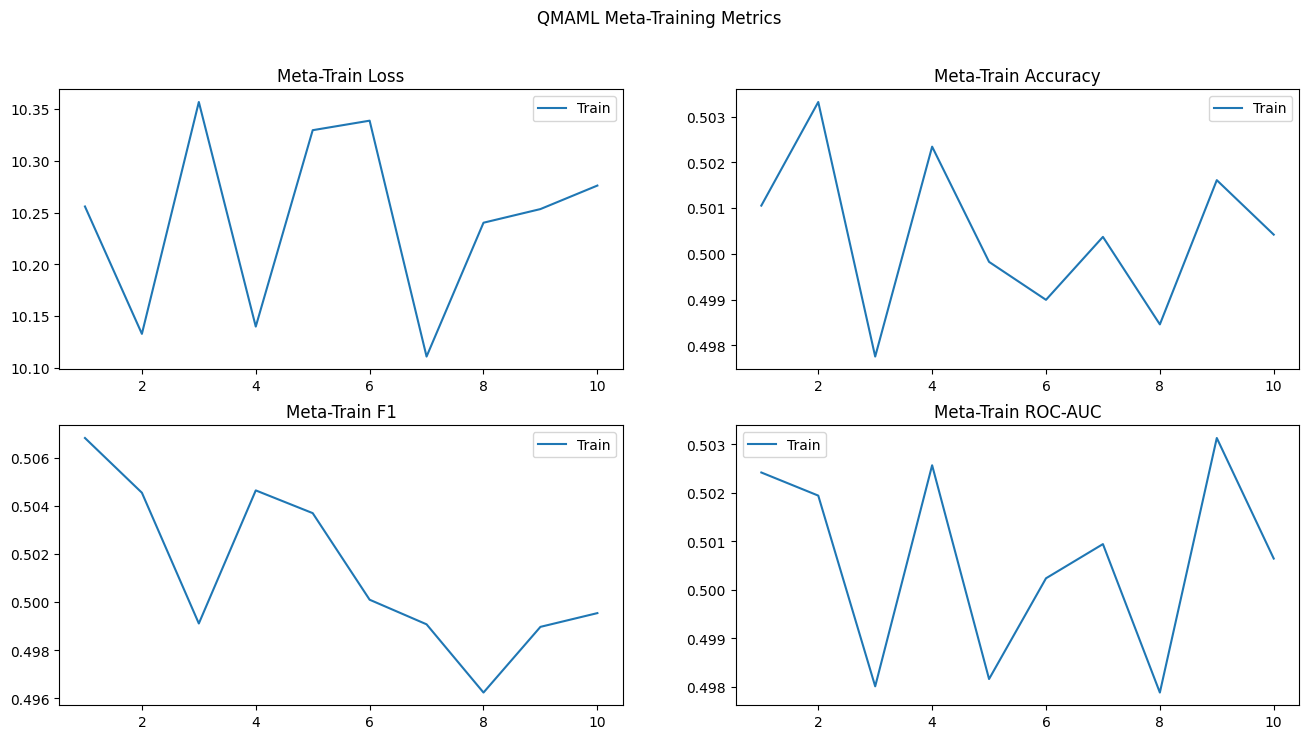

Meta-testing (adaptation)...
Meta-test: Acc 0.5015, F1 0.4985, ROC 0.5004


In [12]:
# 9. Run the QMAML pipeline
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print("Loading data...")
    train_dataset = HiggsDataset(CSV_PATH, n_samples=N_TRAIN)
    test_dataset = HiggsDataset(CSV_PATH, n_samples=N_META_TEST, offset=N_TRAIN)
    print("Preparing meta-tasks...")
    meta_train_tasks = prepare_meta_tasks(train_dataset, META_TRAIN_TASKS, N_CLASSES, META_SUPPORT // N_CLASSES, META_QUERY // N_CLASSES)
    meta_test_tasks = prepare_meta_tasks(test_dataset, META_TEST_TASKS, N_CLASSES, META_SUPPORT // N_CLASSES, META_QUERY // N_CLASSES)
    print("Initializing PQC meta-initializer and PQC-to-MLP mapper...")
    pqc_meta_init = PQCMetaInitializer(N_QUBITS, PQC_LAYERS, N_QUBITS)
    dummy_mlp = PhysicsMLP(N_FEATURES, HIDDEN_SIZE, N_CLASSES, n_layers=N_LAYERS, dropout=DROPOUT)
    mlp_param_dim = sum(p.numel() for p in dummy_mlp.parameters())
    pqc_to_mlp = PQCtoMLPMapper(N_QUBITS, mlp_param_dim, hidden_dims=PQC_TO_MLP_HIDDEN)
    print("Meta-training (QMAML)...")
    pqc_meta_init, pqc_to_mlp, history = qmaml_meta_train(
        meta_train_tasks, pqc_meta_init, pqc_to_mlp, PQC_LAYERS, N_QUBITS, N_EPOCHS,
        META_INNER_STEPS, META_INNER_LR, META_OUTER_LR, device
    )
    plot_metrics(history, title="QMAML Meta-Training Metrics")
    print("Meta-testing (adaptation)...")
    qmaml_meta_adaptation(pqc_meta_init, pqc_to_mlp, meta_test_tasks, META_INNER_STEPS, META_INNER_LR, device)